In [1]:
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau
from imblearn.over_sampling import RandomOverSampler 
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

# **Loading the Dataset**

In [2]:
FilePath = "../input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv"
dataSet = pd.read_csv(FilePath)

In [3]:
Label = dataSet["label"]
Data = dataSet.drop(columns=["label"]) 

**Count labels using countlabel() method**

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

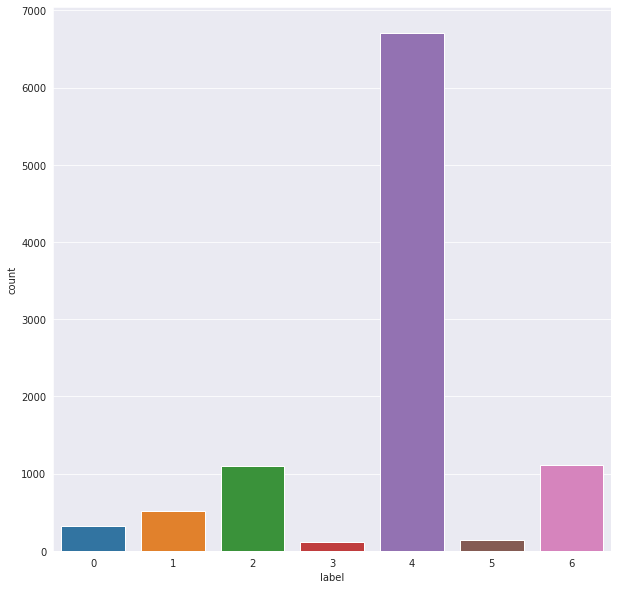

In [4]:
plt.figure(figsize = (10,10))
sns.set_style("darkgrid")
sns.countplot(Label)

**As you see the data is imbalanced , so let's make it balanced**

In [5]:
oversample = RandomOverSampler()
Data,Label  = oversample.fit_resample(Data,Label)
Data = np.array(Data).reshape(-1,28,28,3)
print('Shape of Data :',Data.shape)

Shape of Data : (46935, 28, 28, 3)


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

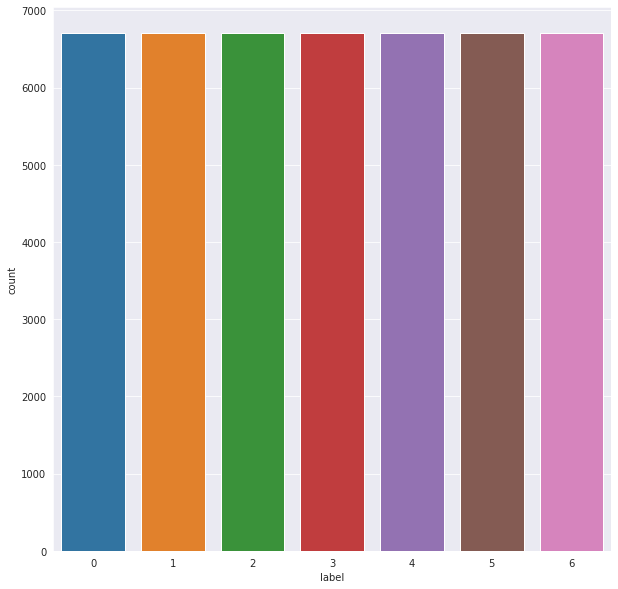

In [6]:
plt.figure(figsize = (10,10))
sns.set_style("darkgrid")
sns.countplot(Label)

In [7]:
Label = np.array(Label)
Label

array([2, 2, 2, ..., 6, 6, 6])

In [8]:
classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2 :('bkl', 'benign keratosis-like lesions'), 
           1:('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}

**SPLIT DATA INTO TRAIN AND TEST DATA**

***

In [9]:
X_train , X_test , y_train , y_test = train_test_split(Data , Label , test_size = 0.25 , random_state = 49)

In [10]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(35201, 28, 28, 3)
(11734, 28, 28, 3)
(35201,)
(11734,)


**Plot images**

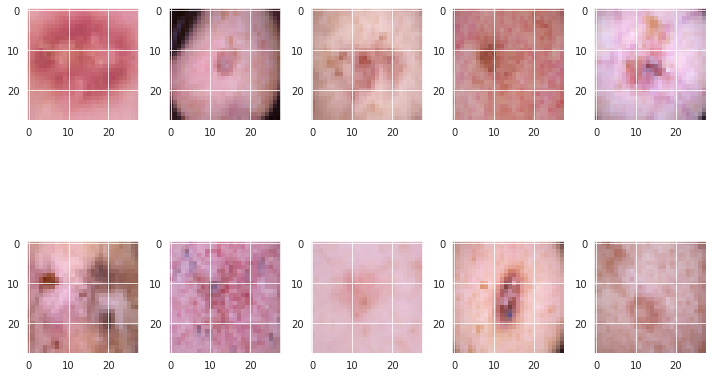

In [11]:
f , ax = plt.subplots(2,5)
f.set_size_inches(10, 10)
k = 0 
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(X_train[k].reshape(28,28,3))
        k = k + 1
    plt.tight_layout()

**Convert lables into One-hot encoding**

In [12]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [13]:
print(y_train)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


**use Data Augmentation to avoid Overfitting , using by ImageDataGenerator method**

In [14]:
datagen = ImageDataGenerator(rescale=(1./255)
                             ,rotation_range=10
                             ,zoom_range = 0.1
                             ,width_shift_range=0.1
                             ,height_shift_range=0.1)
testgen = ImageDataGenerator(rescale=(1./255))

**Learing Rate Decay**

In [15]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.5
                                            , min_lr=0.00001)

# **Build Our Model**

In [16]:
def My_Model():
  input_ = keras.layers.Input(shape = [28,28,3])
  x = keras.layers.Conv2D(32 , (3,3) , activation='relu',padding='same' , kernel_initializer='he_normal')(input_)
  x = keras.layers.MaxPooling2D()(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv2D(64 , (3,3) , activation='relu',padding='same' , kernel_initializer='he_normal')(x)
  x = keras.layers.Conv2D(64 , (3,3) , activation='relu',padding='same' , kernel_initializer='he_normal')(x)
  x = keras.layers.MaxPooling2D()(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv2D(128 , (3,3) , activation='relu',padding='same' , kernel_initializer='he_normal')(x)
  x = keras.layers.Conv2D(128 , (3,3) , activation='relu',padding='same' , kernel_initializer='he_normal')(x)
  x = keras.layers.MaxPooling2D()(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv2D(256 , (3,3) , activation='relu' ,padding='same', kernel_initializer='he_normal')(x)
  x = keras.layers.Conv2D(256 , (3,3) , activation='relu' ,padding='same', kernel_initializer='he_normal')(x)
  x = keras.layers.MaxPooling2D()(x)
  flatten  = keras.layers.Flatten()(x)
  classifier = keras.layers.Dropout(rate = 0.2)(flatten)
  classifier = keras.layers.Dense(units = 256 , activation = 'relu' , kernel_initializer = 'he_normal')(classifier)
  classifier = keras.layers.BatchNormalization()(classifier)
  classifier = keras.layers.Dense(units = 128 , activation = 'relu' , kernel_initializer = 'he_normal')(classifier)
  classifier = keras.layers.BatchNormalization()(classifier)
  classifier = keras.layers.Dense(units = 64 , activation = 'relu' , kernel_initializer = 'he_normal')(classifier)
  classifier = keras.layers.BatchNormalization()(classifier) 
  classifier = keras.layers.Dense(units = 32 , activation = 'relu' , kernel_initializer = 'he_normal' , kernel_regularizer=keras.regularizers.L1L2())(classifier)
  classifier = keras.layers.BatchNormalization()(classifier) 
  classifier = keras.layers.Dense(units = 7 , activation='softmax' ,kernel_initializer="glorot_uniform" , name = 'classifier')(classifier)

  return keras.models.Model(inputs = input_  ,outputs =  classifier  )
  

In [17]:
model = My_Model()

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0     

**plot model to see connected layers**

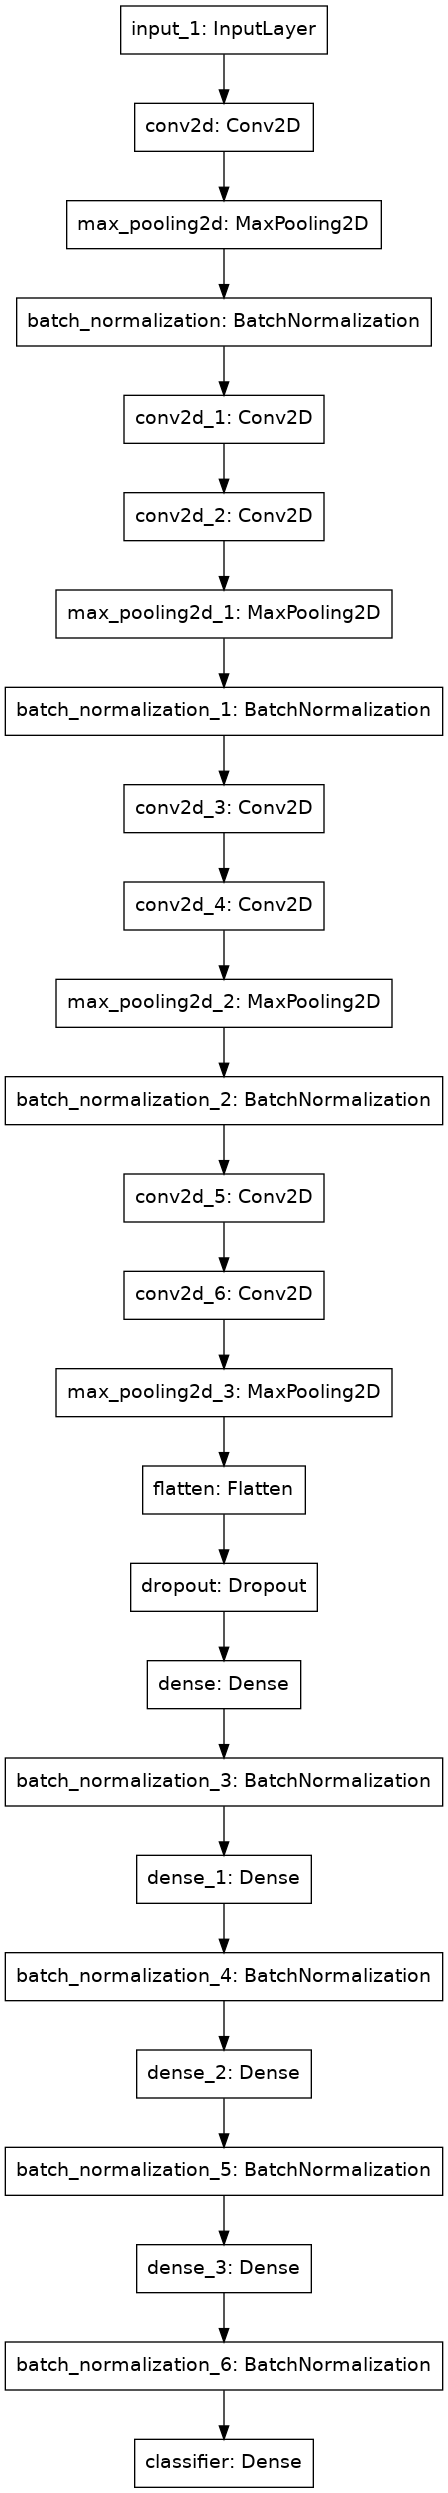

In [19]:
keras.utils.plot_model(model)

In [20]:
model.compile(optimizer='adam' , loss = keras.losses.CategoricalCrossentropy() ,metrics = ['accuracy'])

**Training step**

In [21]:
history = model.fit(X_train ,
                    y_train ,
                    epochs=25 ,
                    batch_size=128,
                    validation_data=(X_test , y_test) ,
                    callbacks=[learning_rate_reduction])

Epoch 1/25
276/276 [==============================] - 20s 51ms/step - loss: 1.4828 - accuracy: 0.4516 - val_loss: 0.8995 - val_accuracy: 0.6566
Epoch 2/25
276/276 [==============================] - 13s 47ms/step - loss: 0.5077 - accuracy: 0.8268 - val_loss: 1.6396 - val_accuracy: 0.5215
Epoch 3/25
276/276 [==============================] - 13s 47ms/step - loss: 0.2538 - accuracy: 0.9070 - val_loss: 0.3161 - val_accuracy: 0.8876
Epoch 4/25
276/276 [==============================] - 13s 47ms/step - loss: 0.1822 - accuracy: 0.9356 - val_loss: 0.2718 - val_accuracy: 0.9070
Epoch 5/25
276/276 [==============================] - 13s 47ms/step - loss: 0.1219 - accuracy: 0.9584 - val_loss: 0.3541 - val_accuracy: 0.8925
Epoch 6/25
276/276 [==============================] - 13s 47ms/step - loss: 0.1109 - accuracy: 0.9624 - val_loss: 0.2833 - val_accuracy: 0.9210
Epoch 7/25
276/276 [==============================] - 13s 47ms/step - loss: 0.0843 - accuracy: 0.9697 - val_loss: 0.3198 - val_accuracy:

In [22]:
model.evaluate(X_test , y_test)

367/367 [==============================] - 4s 11ms/step - loss: 0.1003 - accuracy: 0.9838


[0.10033588856458664, 0.9838077425956726]

# Analysis after Training

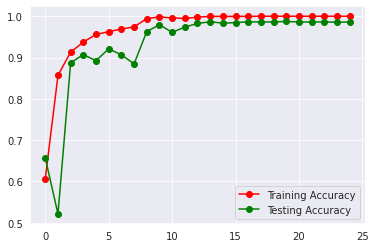

In [23]:
plt.plot(history.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()


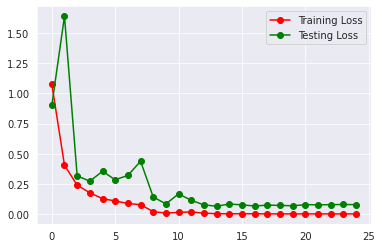

In [24]:
plt.plot(history.history["loss"] , 'ro-' , label = "Training Loss")
plt.plot(history.history["val_loss"] , 'go-' , label = "Testing Loss")
plt.legend()
plt.show()

In [25]:
y_pred  = model.predict(X_test).round()

In [26]:
target_names = [f"{classes[i]}" for i in range(7)]
print(classification_report(y_test , y_pred , target_names =target_names ))

                                                               precision    recall  f1-score   support

('akiec', 'Actinic keratoses and intraepithelial carcinomae')       1.00      1.00      1.00      1667
                             ('bcc', ' basal cell carcinoma')       0.99      1.00      1.00      1689
                     ('bkl', 'benign keratosis-like lesions')       0.97      0.99      0.98      1651
                                     ('df', 'dermatofibroma')       1.00      1.00      1.00      1629
                                  ('nv', ' melanocytic nevi')       0.98      0.92      0.95      1663
              ('vasc', ' pyogenic granulomas and hemorrhage')       1.00      1.00      1.00      1680
                                          ('mel', 'melanoma')       0.96      0.99      0.97      1755

                                                    micro avg       0.98      0.98      0.98     11734
                                                    macro avg       0.9

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

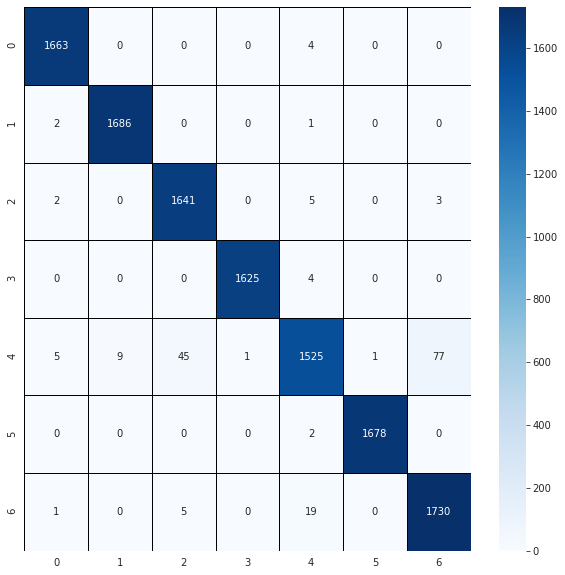

In [27]:
cm = confusion_matrix(y_test.argmax(axis = 1) , y_pred.argmax(axis = 1))
cm = pd.DataFrame(cm , index = [i for i in range(7)] , columns = [i for i in range(7)])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

**Plot Test Images**

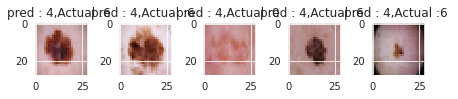

In [28]:
correct = np.nonzero(y_pred == y_test)[0]

k = 0 
for c in correct[:10]:
            plt.subplot(2,5,k+1)
            plt.imshow(X_test[k].reshape(28,28,3) , interpolation='none')
            plt.title(f"pred : {y_pred[k].argmax(axis = 0)},Actual :{y_test[k].argmax(axis = 0)} ")
            plt.tight_layout()
            k += 1

In [29]:
model.save('DEPI_SKIN_CANCER_MODEL.h5')